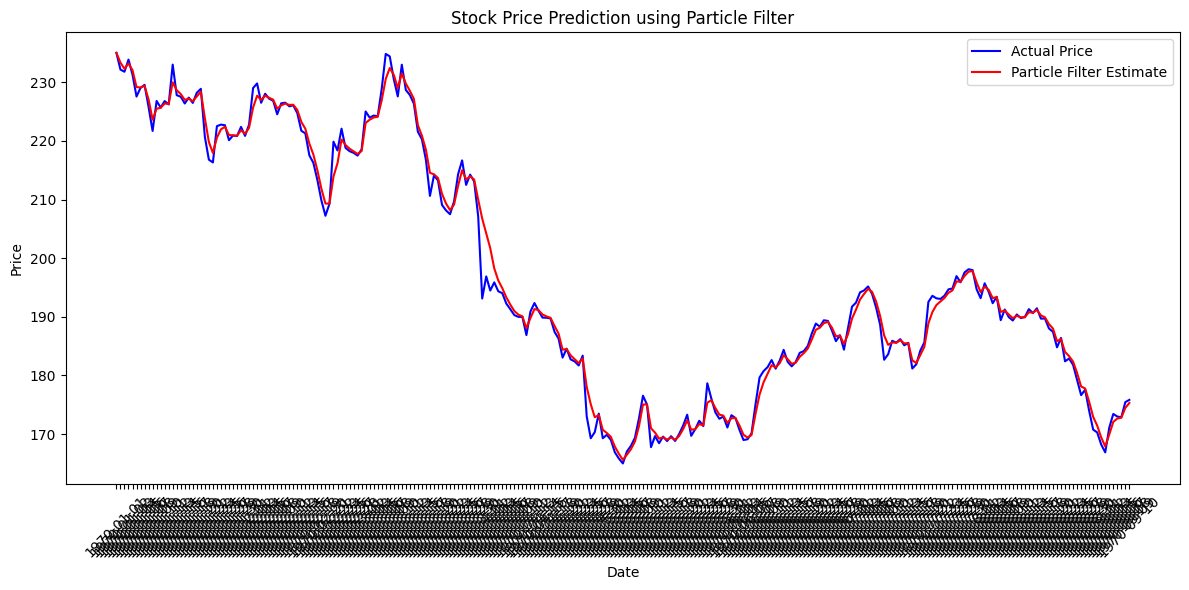

Initial Price: 235.0
Final Price: 175.84
Final Particle Filter Estimate: 175.31475767189644
Mean Absolute Error: 1.036454073305009


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter


class ParticleFilter:
    def __init__(self, num_particles, initial_price, process_variance, measurement_variance):
        self.num_particles = num_particles
        self.particles = np.full(num_particles, initial_price)
        self.weights = np.ones(num_particles) / num_particles
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance

    def predict(self):
        # Move particles according to the process model (random walk in this case)
        self.particles += np.random.normal(0, np.sqrt(self.process_variance), self.num_particles)

    def update(self, measurement):
        # Calculate the likelihood of each particle
        likelihoods = np.exp(-0.5 * ((self.particles - measurement) ** 2) / self.measurement_variance)

        # Update weights
        self.weights *= likelihoods
        self.weights /= np.sum(self.weights)  # Normalize weights

        # Resample particles
        if self.effective_sample_size() < self.num_particles / 2:
            indices = np.random.choice(self.num_particles, self.num_particles, p=self.weights)
            self.particles = self.particles[indices]
            self.weights = np.ones(self.num_particles) / self.num_particles

    def estimate(self):
        return np.sum(self.particles * self.weights)

    def effective_sample_size(self):
        return 1 / np.sum(np.square(self.weights))


def generate_stock_data():
    df = pd.read_csv('../data/apple_stock.csv')
    dates = df['Date']
    prices = df['Close']

    return pd.DataFrame({'Date': dates, 'Price': prices})


def apply_particle_filter(df, num_particles, process_variance, measurement_variance):
    pf = ParticleFilter(num_particles, df['Price'].iloc[0], process_variance, measurement_variance)
    estimates = []

    for price in df['Price']:
        pf.predict()
        pf.update(price)
        estimates.append(pf.estimate())

    df['ParticleEstimate'] = estimates
    return df


def plot_results(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df['Date'], df['Price'], label='Actual Price', color='blue')
    ax.plot(df['Date'], df['ParticleEstimate'], label='Particle Filter Estimate', color='red')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title('Stock Price Prediction using Particle Filter')
    ax.legend()
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Example usage
np.random.seed(42)  # for reproducibility
days = 100
initial_price = 100
volatility = 0.02
num_particles = 1000
process_variance = 1.0
measurement_variance = 1.0

# Generate stock data
df = generate_stock_data()

# Apply particle filter
df = apply_particle_filter(df, num_particles, process_variance, measurement_variance)

# Plot results
plot_results(df)

# Print some statistics
print("Initial Price:", df['Price'].iloc[0])
print("Final Price:", df['Price'].iloc[-1])
print("Final Particle Filter Estimate:", df['ParticleEstimate'].iloc[-1])
print("Mean Absolute Error:", np.mean(np.abs(df['Price'] - df['ParticleEstimate'])))